In [1]:
!git clone https://github.com/chiranthancv95/EVA6_TSAI

Cloning into 'EVA6_TSAI'...
remote: Enumerating objects: 331, done.
remote: Counting objects: 100% (331/331), done.
remote: Compressing objects: 100% (257/257), done.
remote: Total 331 (delta 156), reused 222 (delta 70), pack-reused 0
Receiving objects: 100% (331/331), 47.49 MiB | 26.17 MiB/s, done.
Resolving deltas: 100% (156/156), done.
Checking out files: 100% (135/135), done.


In [2]:
# !rm /content/EVA6_TSAI -r

In [3]:
!pip install git+https://github.com/albumentations-team/albumentations.git
!pip install torchsummary
!pip install torch-lr-finder
!pip install torchscan

  Cloning https://github.com/albumentations-team/albumentations.git to /tmp/pip-req-build-llcwp5us
  Running command git clone -q https://github.com/albumentations-team/albumentations.git /tmp/pip-req-build-llcwp5us
  Created wheel for albumentations: filename=albumentations-1.0.2-cp37-none-any.whl size=98521 sha256=80dbef382dc4433060ffcdc566ead192405c3c37961538c0767fb3ed13004916
  Stored in directory: /tmp/pip-ephem-wheel-cache-bck3qdsi/wheels/e2/85/3e/2a40fac5cc1f43ced656603bb2fca1327b30ec7de1b1b66517
Successfully built albumentations


In [4]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from torchsummary import summary
from torchscan import summary

# Let's visualize some of the images
#%matplotlib inline
import matplotlib.pyplot as plt
import argparse

from torch.optim.lr_scheduler import StepLR,OneCycleLR

from EVA6_TSAI.Session9.train import *
from EVA6_TSAI.Session9.test import *
#from model import *
from EVA6_TSAI.Session9.plotter import *
from EVA6_TSAI.Session9.data import *
# from model_group_norm import *
# from model_layer_norm import *

#from EVA6_TSAI.Session9.parser_args import norm, epochs
from EVA6_TSAI.Session9.custom_resnet import *

%matplotlib inline
import cv2
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm 

from torch.optim.lr_scheduler import StepLR,OneCycleLR

In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? True


In [6]:
# train dataloader
train_loader = load_train()

# test dataloader
test_loader = load_test()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


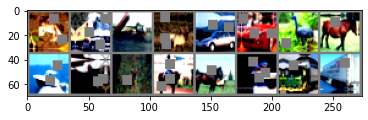

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
# imshow(torchvision.utils.make_grid(images["image"]))

imshow(torchvision.utils.make_grid(images[:16]))
# print labels
# print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [8]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Using: ",device)

Using:  cuda


In [9]:
model = CustomResNet().to(device)

In [10]:
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
       BasicBlock-14          [-1, 128,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [11]:
from torchscan import summary

summary(model, (3, 32, 32), receptive_field=True, max_depth=1)

____________________________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #         Receptive field
baseresnet                   BaseResNet            (-1, 10)                  0               88             
├─prep_layer                 Sequential            (-1, 64, 32, 32)          1,985           88             
├─layer1                     Sequential            (-1, 128, 16, 16)         74,241          86             
├─residual_module1           BasicBlock            (-1, 128, 16, 16)         295,938         42             
├─layer2                     Sequential            (-1, 256, 8, 8)           295,937         38             
├─layer3                     Sequential            (-1, 512, 4, 4)           1,181,697       18             
├─residual_module2           BasicBlock            (-1, 512, 4, 4)           4,722,690       8              
├─pool             

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.64E-01


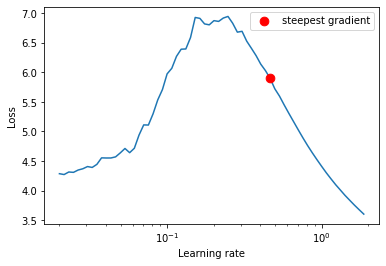

(<matplotlib.axes._subplots.AxesSubplot at 0x7ff442bb2890>,
 0.46415888336127803)

In [12]:
from torch_lr_finder import LRFinder

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
#lr_finder.reset() # to reset the model and optimizer to their initial state


In [13]:
min_loss = min(lr_finder.history['loss'])
lr_rate = lr_finder.history['lr'][np.argmin(lr_finder.history['loss'], axis=0)]
print("Max LR is {}".format(lr_rate))

Max LR is 0.01


In [15]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
#                                                 max_lr=lr_rate/10,
#                                                 steps_per_epoch=len(train_loader), 
#                                                 epochs=24,
#                                                 pct_start=0.01,
#                                                 div_factor=10, 
#                                                 final_div_factor=50,
#                                                 anneal_strategy='linear'
#                                                 )
scheduler = OneCycleLR(optimizer, max_lr=0.015, epochs=90, steps_per_epoch=len(train_loader))
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []
train_acc=0
train_loss=0
epochs=24
for epoch in range(1, epochs + 1):
    print(f'Epoch {epoch}:')
    train_acc, train_loss = train(model, device, train_loader, optimizer, scheduler, criterion)
    train_accuracy.append(train_acc)
    train_losses.append(train_loss)

  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 1:


Loss=325.10772705078125 Batch_id=97 Accuracy=17.33: 100%|██████████| 98/98 [00:22<00:00,  4.44it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 2:


Loss=191.1824493408203 Batch_id=97 Accuracy=17.33: 100%|██████████| 98/98 [00:22<00:00,  4.44it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 3:


Loss=146.5709991455078 Batch_id=97 Accuracy=17.14: 100%|██████████| 98/98 [00:22<00:00,  4.42it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 4:


Loss=127.70669555664062 Batch_id=97 Accuracy=12.57: 100%|██████████| 98/98 [00:22<00:00,  4.39it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 5:


Loss=182.21038818359375 Batch_id=97 Accuracy=11.44: 100%|██████████| 98/98 [00:22<00:00,  4.38it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 6:


Loss=122.80685424804688 Batch_id=97 Accuracy=11.66: 100%|██████████| 98/98 [00:22<00:00,  4.31it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 7:


Loss=115.94099426269531 Batch_id=97 Accuracy=13.19: 100%|██████████| 98/98 [00:22<00:00,  4.28it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 8:


Loss=110.91459655761719 Batch_id=97 Accuracy=13.13: 100%|██████████| 98/98 [00:23<00:00,  4.24it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 9:


Loss=107.05242919921875 Batch_id=97 Accuracy=13.70: 100%|██████████| 98/98 [00:23<00:00,  4.23it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 10:


Loss=104.79792022705078 Batch_id=97 Accuracy=13.92: 100%|██████████| 98/98 [00:23<00:00,  4.21it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 11:


Loss=103.33926391601562 Batch_id=97 Accuracy=13.75: 100%|██████████| 98/98 [00:23<00:00,  4.18it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 12:


Loss=101.44933319091797 Batch_id=97 Accuracy=13.66: 100%|██████████| 98/98 [00:23<00:00,  4.16it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 13:


Loss=99.97290802001953 Batch_id=97 Accuracy=14.09: 100%|██████████| 98/98 [00:23<00:00,  4.16it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 14:


Loss=99.25672912597656 Batch_id=97 Accuracy=15.06: 100%|██████████| 98/98 [00:23<00:00,  4.15it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 15:


Loss=98.62643432617188 Batch_id=97 Accuracy=15.95: 100%|██████████| 98/98 [00:23<00:00,  4.13it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 16:


Loss=96.43607330322266 Batch_id=97 Accuracy=16.73: 100%|██████████| 98/98 [00:23<00:00,  4.11it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 17:


Loss=93.63674926757812 Batch_id=97 Accuracy=17.44: 100%|██████████| 98/98 [00:23<00:00,  4.10it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 18:


Loss=92.59060668945312 Batch_id=97 Accuracy=17.59: 100%|██████████| 98/98 [00:23<00:00,  4.11it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 19:


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 20:


Loss=88.92650604248047 Batch_id=97 Accuracy=18.75: 100%|██████████| 98/98 [00:23<00:00,  4.09it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 21:


Loss=86.41952514648438 Batch_id=97 Accuracy=19.08: 100%|██████████| 98/98 [00:23<00:00,  4.09it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 22:


Loss=83.93435668945312 Batch_id=97 Accuracy=19.43: 100%|██████████| 98/98 [00:23<00:00,  4.09it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 23:


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 24:


Loss=79.8074722290039 Batch_id=97 Accuracy=19.54: 100%|██████████| 98/98 [00:24<00:00,  4.08it/s]
